# Import and Cleaning

In [1]:
# adding path to import custom functions
import sys
sys.path.append("/home/artur/code/masters-project/main_project/notebooks/model_creation/models")

In [2]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter, gmtime, strftime

from functions import remove_high_corr, scale_variables, best_params_grid, calculate_confusion_matrix, plot_roc_auc_curve, bart_auc_scorer, make_label, get_error_and_auc

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import RepeatedKFold, train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer

from ISLP.bart import BART

import session_info 

In [3]:
data = pd.read_csv("../../data/fda_approved/fda_mold2_pre_processed_descriptors.csv")
data.head()

,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,...,D768,D769,D770,D771,D772,D773,D774,D775,D776,D777
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,2.00000,3.493810,0.0,-1.457570
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,2.32193,0.523826,0.0,-0.816018
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,2.32193,1.814530,0.0,-1.453400
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,...,0.0,1.0,0.0,0.0,0.0,0.0,0.00000,1.832480,0.0,-0.172449
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,-0.430677,0.0,-0.172449


In [4]:
Y = data["oral"]
Y = Y.astype(float)
Y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: oral, dtype: float64

In [5]:
X = data.iloc[:, 14:]
X.head()

,D001,D002,D003,D004,D005,D006,D007,D008,D009,D010,...,D768,D769,D770,D771,D772,D773,D774,D775,D776,D777
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.00000,3.493810,0.0,-1.457570
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.32193,0.523826,0.0,-0.816018
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.32193,1.814530,0.0,-1.453400
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.00000,1.832480,0.0,-0.172449
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,-0.430677,0.0,-0.172449


In [6]:
# separate train an test datasets

np.random.seed(750059)
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size=0.25)

# Constant Variables

In [7]:
DESCRIPTOR_TYPE = "mold2"

# Scaling datsets

The datasets are being scaled to be used, when necessary, scaled

In [8]:
# TRAIN

x_train_scaled = scale_variables(x_train)

# adding constant
x_train_scaled = sm.add_constant(x_train_scaled)

x_train_scaled.head()

,const,D001,D002,D003,D004,D005,D006,D007,D008,D009,...,D768,D769,D770,D771,D772,D773,D774,D775,D776,D777
0,1.0,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,...,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131
1,1.0,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,...,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131
2,1.0,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,...,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131
3,1.0,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,...,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131
4,1.0,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,...,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131,-0.053131


In [9]:
# TEST

x_test_scaled = scale_variables(x_test)

# adding constant
x_test_scaled = sm.add_constant(x_test_scaled)

x_test_scaled.head()

,const,D001,D002,D003,D004,D005,D006,D007,D008,D009,...,D768,D769,D770,D771,D772,D773,D774,D775,D776,D777
0,1.0,-0.073227,-0.202184,-0.241559,-0.812909,-0.863888,-0.240906,-0.092253,0.0,0.0,...,-0.098683,-0.065094,-0.333129,-0.092253,0.0,-0.113228,-0.982074,0.422130,1.094345,-0.296123
1,1.0,-1.230205,-0.202184,-0.241559,-0.812909,-0.863888,-0.240906,-0.092253,0.0,0.0,...,-0.098683,-0.065094,-0.333129,-0.092253,0.0,-0.113228,-1.325259,0.472210,-1.261621,-0.390417
2,1.0,-1.230205,-0.202184,-0.241559,0.511211,0.764274,-0.240906,-0.092253,0.0,0.0,...,-0.098683,-0.065094,-0.333129,-0.092253,0.0,-0.113228,0.311664,-0.705069,-1.261621,1.158507
3,1.0,-0.073227,-0.202184,-0.241559,-0.812909,-0.049807,-0.240906,-0.092253,0.0,0.0,...,-0.098683,-0.065094,-0.333129,-0.092253,0.0,-0.113228,0.358234,-0.248093,-0.205495,-0.175230
4,1.0,-1.230205,4.153963,-0.241559,-0.812909,-1.677969,-0.240906,-0.092253,0.0,0.0,...,-0.098683,-0.065094,2.059346,-0.092253,0.0,-0.113228,-0.057149,0.863992,-1.261621,-1.486480


# Logistic Regression

## Model Constant Variables

In [10]:
model_name_title = "Logistic Regression"
model_name_path = "logistic_regression"

## Cross Validation

Here, I will use the best_params_grid function, which looks for the best hyperparameters, using CV. There are no hyperparameters in Logistic Regression, so this function will only perform CV.

In [11]:
model_params_lr = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {}
    }
}

In [12]:
gs_result_lr, gs_result_lr_full = best_params_grid(x_train, y_train, model_params_lr)

Starting Grid Search for Logistic Regression: 13:24


/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Finished Grid Search for Logistic Regression: 13:24
Tempo de execução:  0.0 minutos


In [13]:
gs_result_lr

,model,best_score,best_params
0,Logistic Regression,0.521203,{}


## Fitting Model to Train Dataset

To fit the model, I will use the Logit function, from the statsmodel library, because it gives more information about feature importance.

In [14]:
# adjusting y_train index and type

y_train.index = range(0, x_train_scaled.shape[0])

In [15]:
# calculatin model
log_reg = sm.Logit(y_train, x_train_scaled).fit(method='bfgs')
log_reg_results = log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.662573
         Iterations: 9
         Function evaluations: 14
         Gradient evaluations: 14


/home/artur/Programs/mambaforge/envs/islp/lib/python3.12/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


## Get Training Error and AUC

In [16]:
mis_rate_lr_train, auc_lr_train = get_error_and_auc(
    model=log_reg, 
    x=x_train_scaled,
    y_true=y_train,
    transform_prob_into_label=True
)

Training Misclassification Rate: 0.3772
Training AUC: 0.5022


## Make Predictions

In [17]:
# the log_reg algorithm predicts as probabilities
y_predict_lr_prob = log_reg.predict(x_test_scaled)

In [18]:
# here I use the make_label function to transform the probabilities into labels, using 0.5 as a cutoff

make_label_v = np.vectorize(make_label)
y_predict_labels_lr = make_label_v(y_predict_lr_prob)

## Test Error

In [19]:
mis_rate_lr, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_labels_lr,
)

Misclassification rate: 0.3797


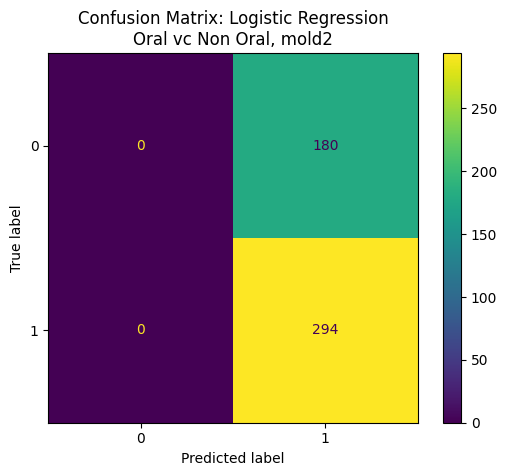

In [20]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

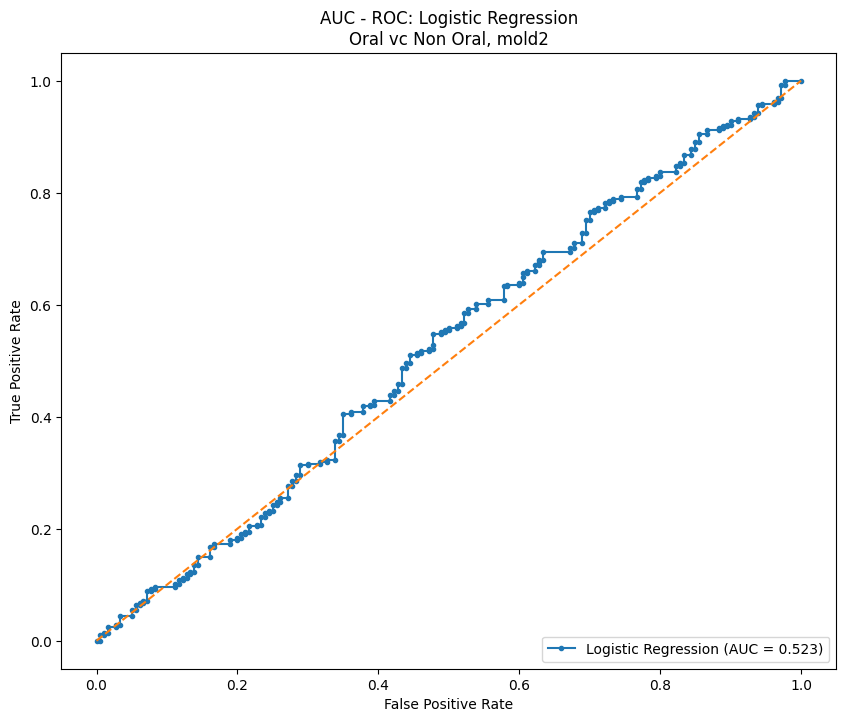

In [21]:
auc_lr = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_lr_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

In [22]:
# converting results summary to pandas dataframe
results_log_reg_html = log_reg_results.tables[1].as_html()
results_log_reg_df = pd.read_html(results_log_reg_html, header=0, index_col=0)[0]
print(results_log_reg_df.shape)
results_log_reg_df.head()

(778, 6)


,coef,std err,z,P>|z|,[0.025,0.975]
const,0.4954,NaN,NaN,NaN,NaN,NaN
D001,-0.0001,NaN,NaN,NaN,NaN,NaN
D002,-0.0001,NaN,NaN,NaN,NaN,NaN
D003,-0.0001,NaN,NaN,NaN,NaN,NaN
D004,-0.0001,NaN,NaN,NaN,NaN,NaN


In [23]:
important_features_lr = results_log_reg_df[results_log_reg_df["P>|z|"] < 0.05]
print(important_features_lr.shape)
important_features_lr

(0, 6)


,coef,std err,z,P>|z|,[0.025,0.975]


## Saving Results

In [24]:
# creating dataset to store final results from each model
final_results = pd.DataFrame(
    columns=[
        "model_name", 
        "cv_test_auc", 
        "training_mis_rate", 
        "test_mis_rate", 
        "training_auc",
        "test_auc"
    ]
)

In [25]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_lr["best_score"][0],
    mis_rate_lr_train,
    mis_rate_lr,
    auc_lr_train,
    auc_lr
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.521203,0.377199,0.379747,0.502222,0.522959


In [26]:
important_features_lr.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# TREES

# Decision Tree

## Model Constant Variables

In [27]:
model_name_title = "Decision Tree"
model_name_path = "decision_tree"

## Hyperparameter Fine Tuning

In [28]:
model_params = {
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': [1, 5, 10, 20, 50, 100, 150],
            'ccp_alpha': [0, 0.0001, 0.001, 0.1, 0.5, 1]
        }
    }
}

In [29]:
gs_result_dt, gs_result_dt_full = best_params_grid(x_train, y_train, model_params)

Starting Grid Search for Decision Tree: 13:24
Finished Grid Search for Decision Tree: 13:49
Tempo de execução:  24.7 minutos


In [30]:
gs_result_dt

,model,best_score,best_params
0,Decision Tree,0.618173,"{'ccp_alpha': 0.0001, 'criterion': 'entropy', ..."


## Fitting Tree

In [31]:
decision_tree_params = gs_result_dt.iloc[0,2]
decision_tree_params

{'ccp_alpha': 0.0001, 'criterion': 'entropy', 'max_depth': 5}

In [32]:
decision_tree = DecisionTreeClassifier(**decision_tree_params).fit(x_train, y_train)

## Get Training Error and AUC

In [33]:
mis_rate_dt_train, auc_dt_train = get_error_and_auc(
    model=decision_tree, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.2435
Training AUC: 0.6897


## Make Predictions

In [34]:
y_predict_dt_label = decision_tree.predict(x_test)
y_predict_dt_prob = decision_tree.predict_proba(x_test)[:, 1]

## Test Error

In [35]:
mis_rate_dt, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_dt_label,
)

Misclassification rate: 0.3333


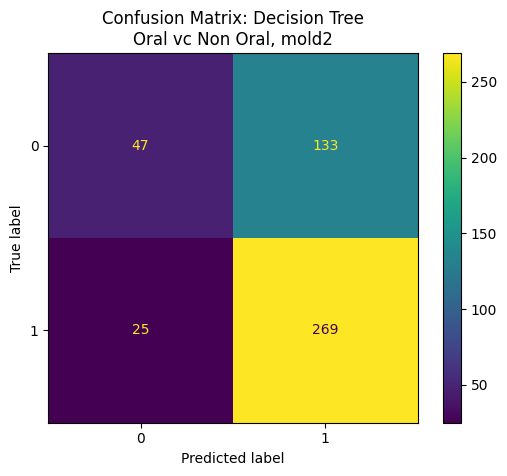

In [36]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

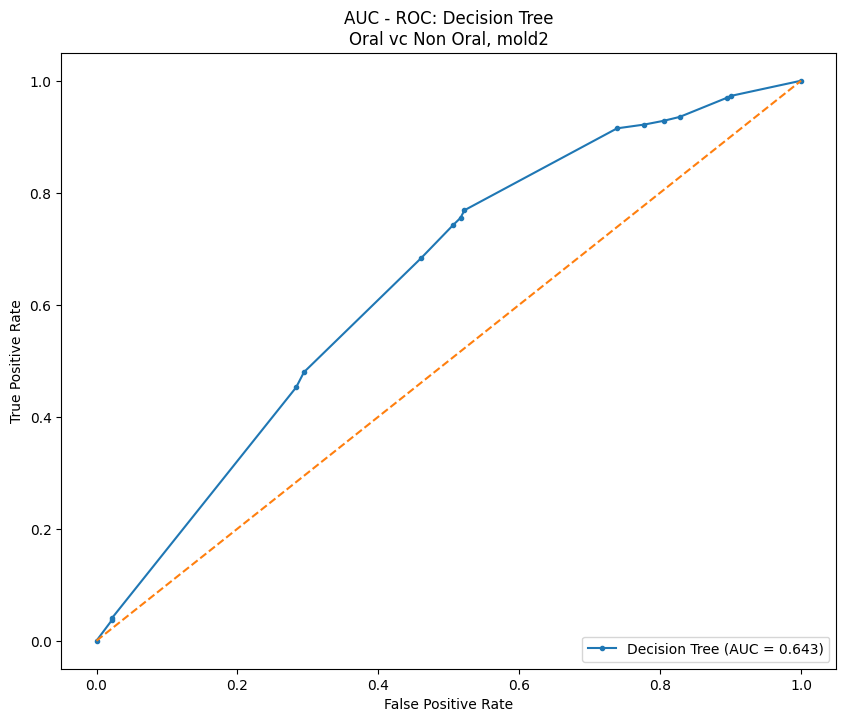

In [37]:
auc_dt = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_dt_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Visualizing the Tree

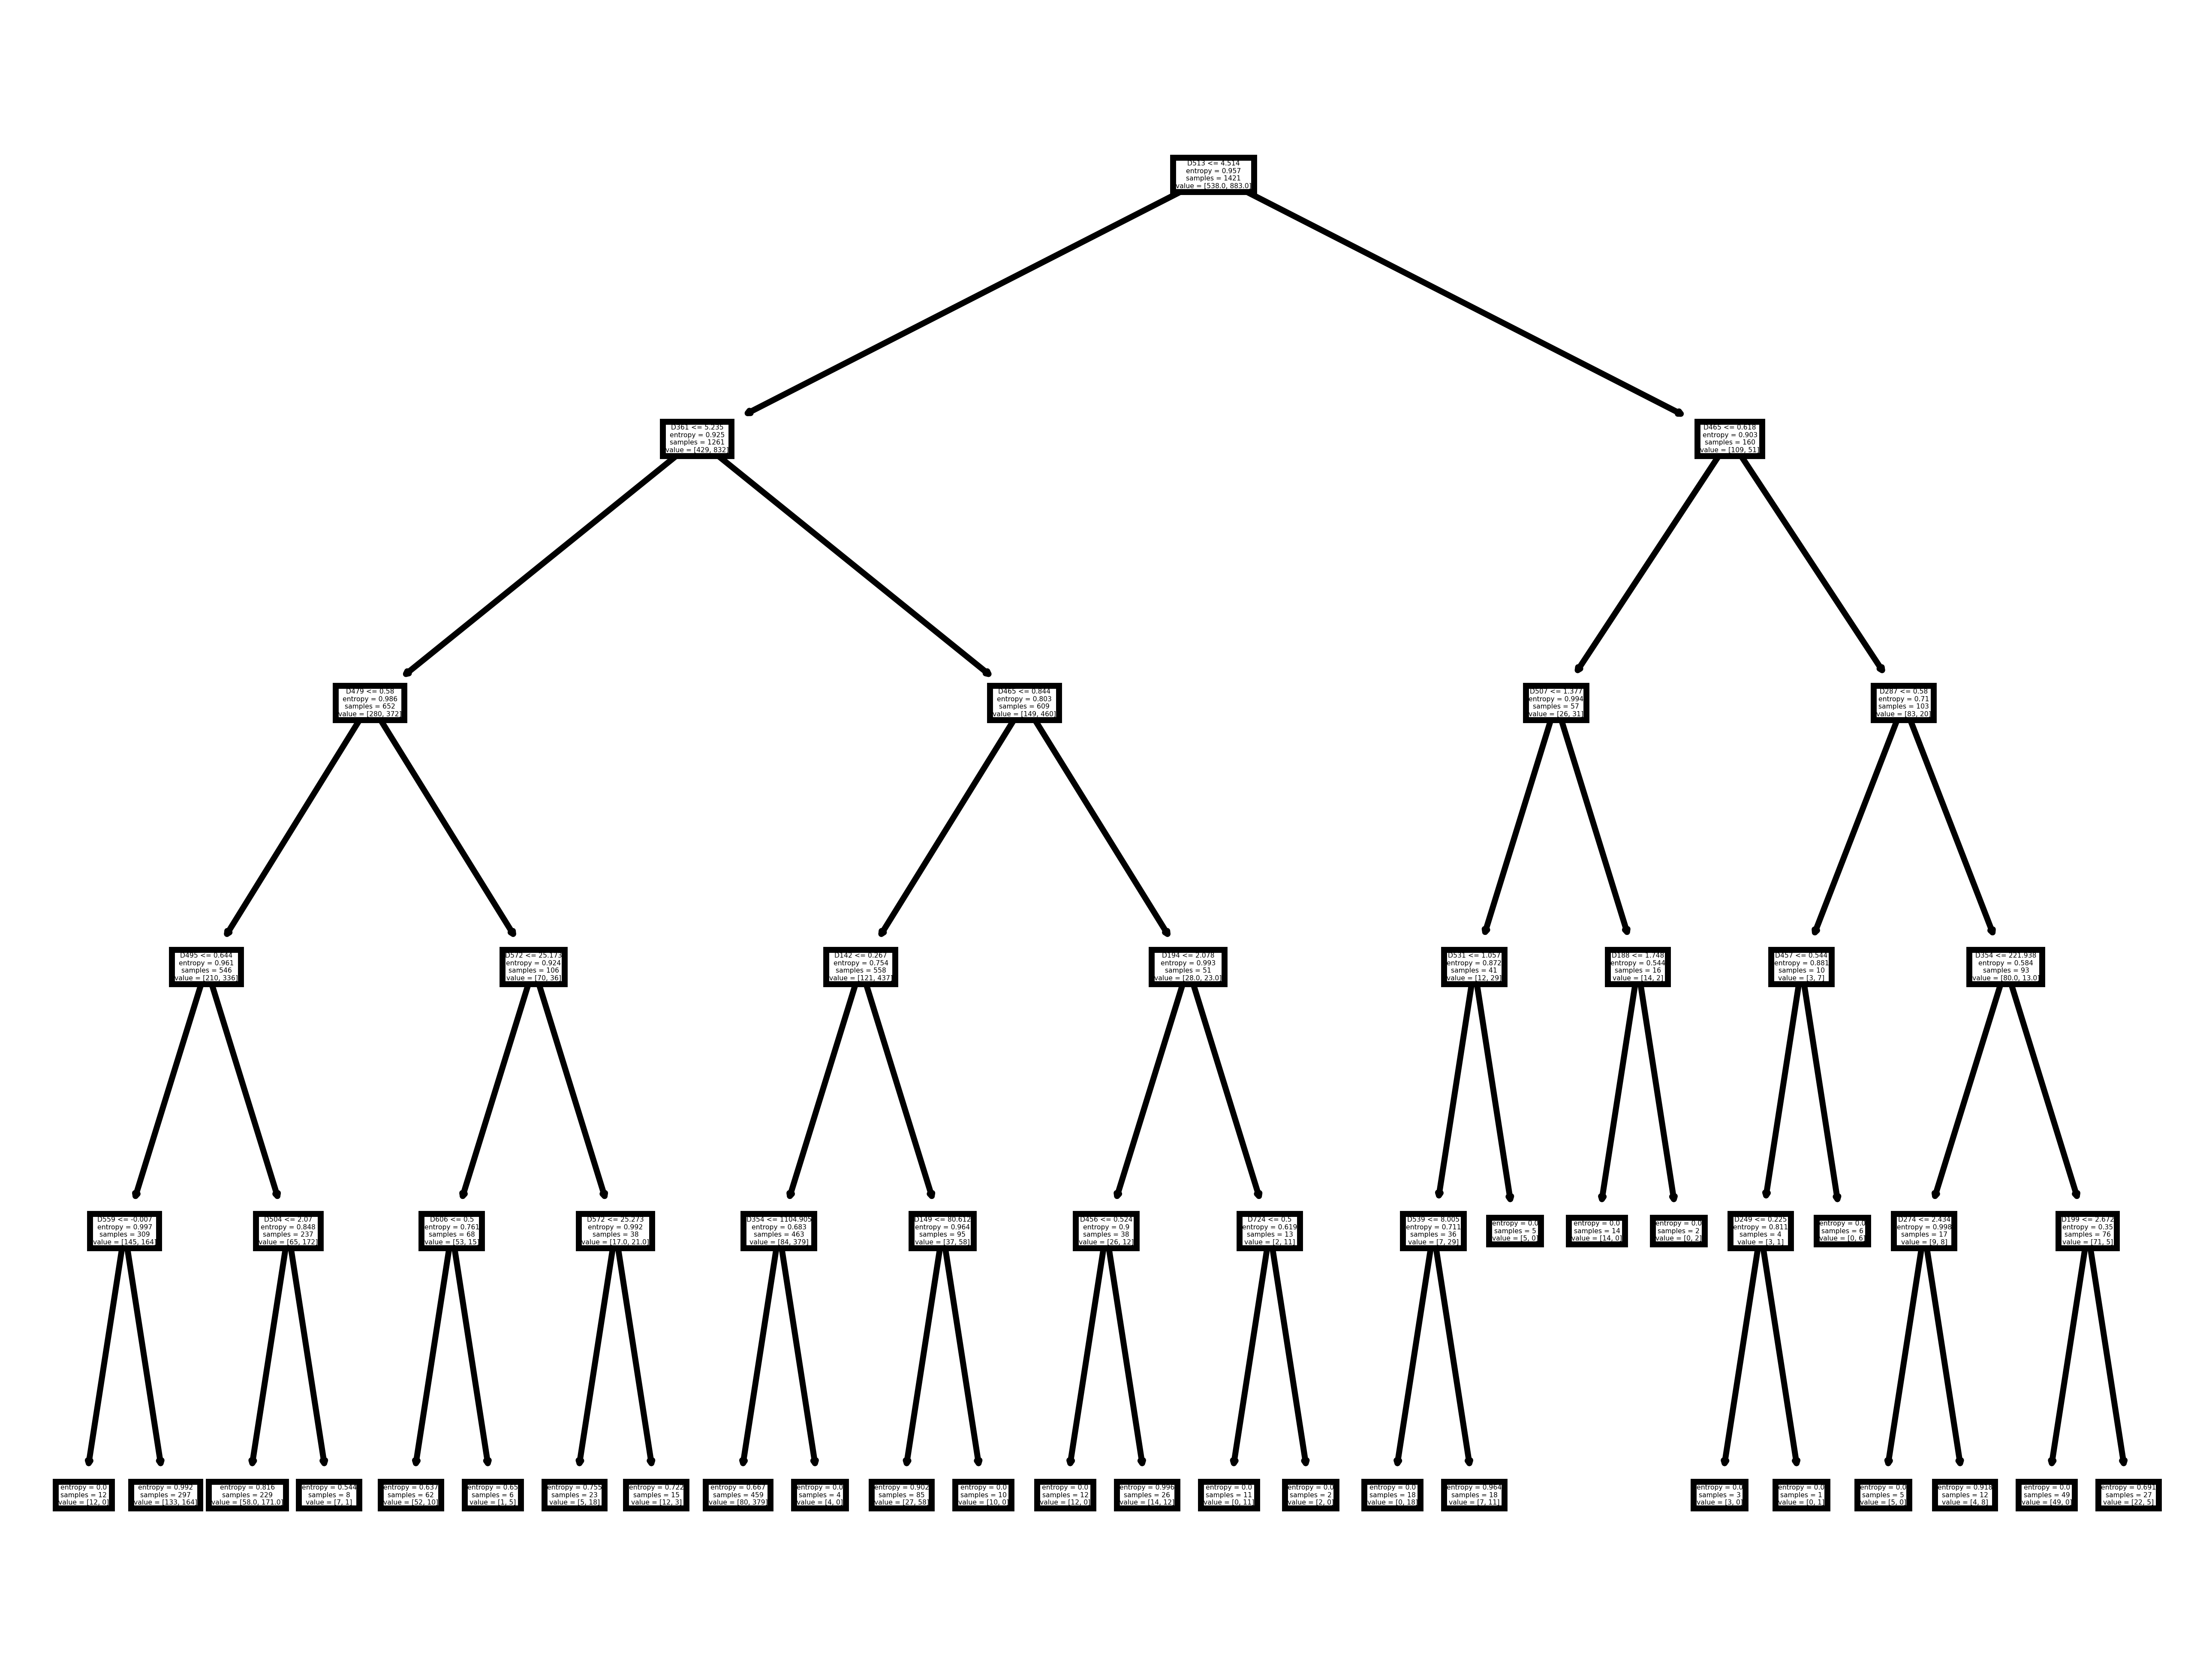

In [38]:
fig, ax = plt.subplots()
fig.dpi = 1000

tree.plot_tree(decision_tree, ax=ax, feature_names=list(x_train.columns))
plt.show()

fig.savefig(f"imgs/decision_tree_{DESCRIPTOR_TYPE}", dpi=1000)

## Feature Importance

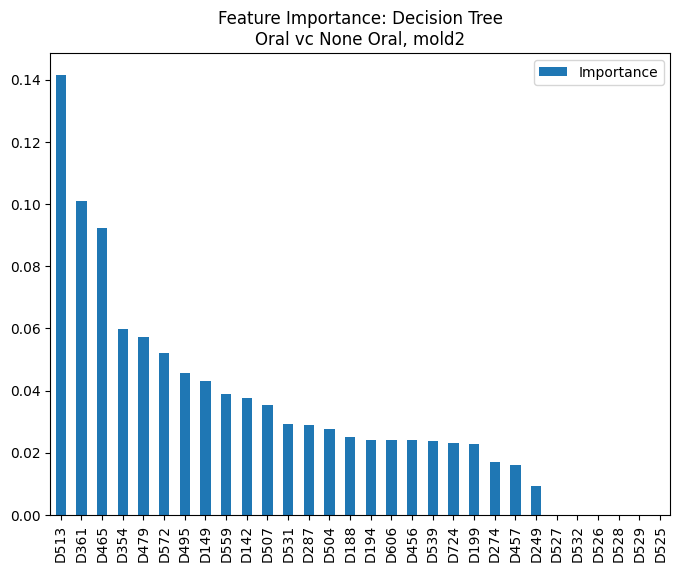

In [39]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(decision_tree.feature_importances_, index=x_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [40]:
important_features_dt = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_dt

,Importance
D249,0.009367
D457,0.016071
D274,0.017140
D199,0.022907
D724,0.023242
D539,0.023758
D456,0.023961
D606,0.024091
D194,0.024256
D188,0.025103


## Saving Results

In [41]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_dt["best_score"][0],
    mis_rate_dt_train,
    mis_rate_dt,
    auc_dt_train,
    auc_dt
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.521203,0.377199,0.379747,0.502222,0.522959
1,Decision Tree,0.618173,0.243490,0.333333,0.689695,0.643188


In [42]:
important_features_dt.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# Random Forest and Bagging

Bagging is just Random Forest, in which max_features is equal to the total number of features. Therefore, bagging will be done in the RF algorithm, and compared to RF.

## Model Constant Variables

In [43]:
model_name_title = "Random Forest"
model_name_path = "random_forest"

## Hyperparameter Fine Tuning

In [48]:
model_params = {
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [500, 1000], # number of trees
            'max_depth': [50, 100],
            'max_features': ["sqrt", "log2", x_train.shape[1]], # m, number of features considered in split. When it is equal to all predictor of dataset, it is bagging
            'ccp_alpha': [0, 0.1, 0.5]
        }
    }
}

In [49]:
gs_result_rf, gs_result_rf_full = best_params_grid(x_train, y_train, model_params)

Starting Grid Search for Random Forest: 10:52
Finished Grid Search for Random Forest: 10:44
Tempo de execução:  1431.9 minutos


In [50]:
gs_result_rf

,model,best_score,best_params
0,Random Forest,0.705692,"{'ccp_alpha': 0, 'max_depth': 50, 'max_feature..."


## Fitting Model

In [51]:
random_forest_params = gs_result_rf.iloc[0,2]
random_forest_params

{'ccp_alpha': 0, 'max_depth': 50, 'max_features': 777, 'n_estimators': 1000}

In [52]:
random_forest = RandomForestClassifier(**random_forest_params).fit(x_train, y_train)

## Get Training Error and AUC

In [53]:
mis_rate_rf_train, auc_rf_train = get_error_and_auc(
    model=random_forest, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.0035
Training AUC: 0.9961


## Make Predictions

In [54]:
y_predict_rf_label = random_forest.predict(x_test)
y_predict_rf_prob = random_forest.predict_proba(x_test)[:, 1]

## Test Error

In [55]:
mis_rate_rf, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_rf_label,
)

Misclassification rate: 0.2890


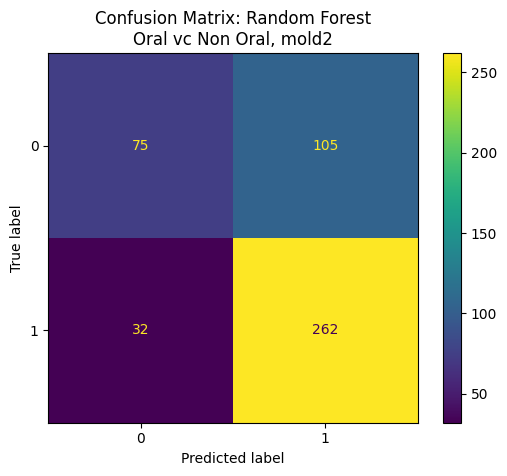

In [56]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

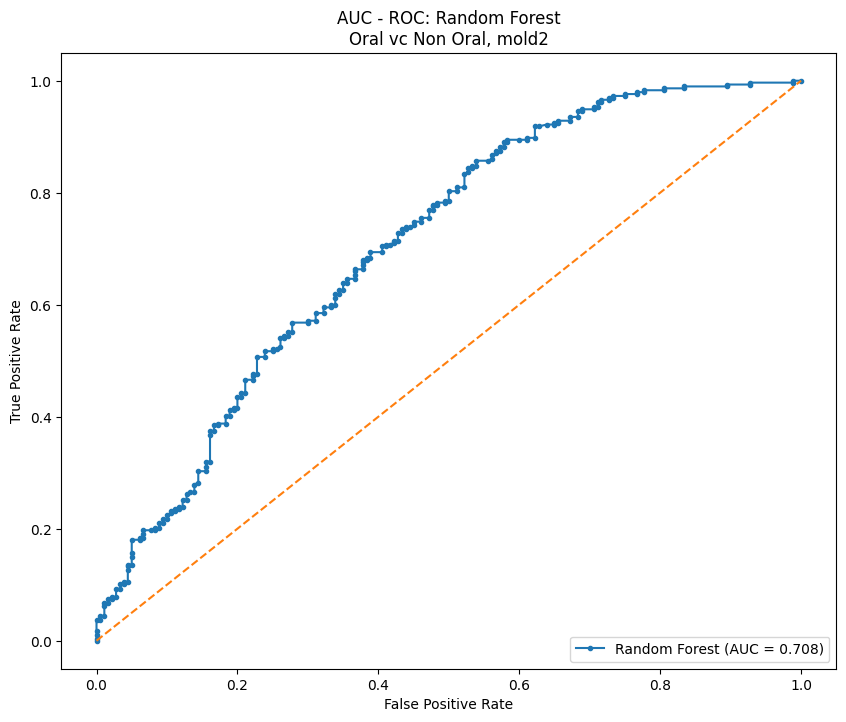

In [57]:
auc_rf = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_rf_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

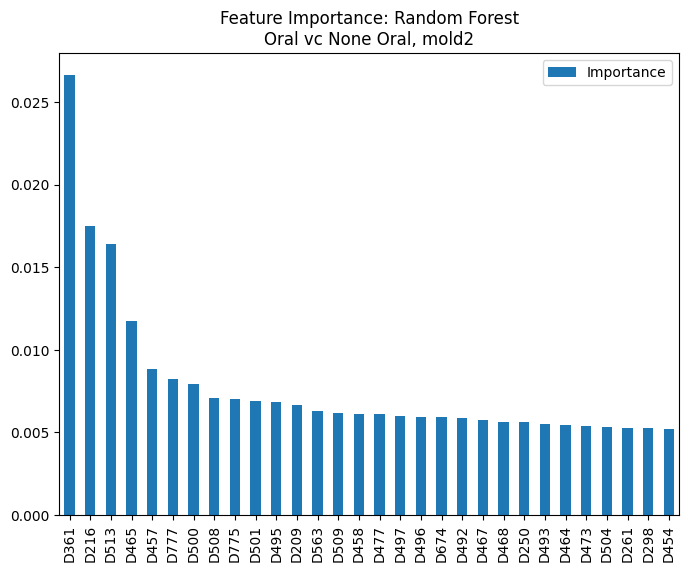

In [58]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(random_forest.feature_importances_, index=x_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [59]:
important_features_rf = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_rf

,Importance
D111,7.155749e-08
D029,9.546588e-08
D095,9.899596e-08
D052,2.162976e-07
D385,2.480670e-07
...,...
D457,8.864929e-03
D465,1.175362e-02
D513,1.641069e-02
D216,1.751692e-02


## Saving Results

In [60]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_rf["best_score"][0],
    mis_rate_rf_train,
    mis_rate_rf,
    auc_rf_train,
    auc_rf
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.521203,0.377199,0.379747,0.502222,0.522959
1,Decision Tree,0.618173,0.243490,0.333333,0.689695,0.643188
2,Random Forest,0.705692,0.003519,0.289030,0.996079,0.707870


In [61]:
important_features_rf.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# Boosting

## Model Constant Variables

In [62]:
model_name_title = "Gradiant Boosting"
model_name_path = "boosting"

## Hyperparameter Fine Tuning

In [63]:
model_params = {
    'Boosting': {
            'model': GradientBoostingClassifier(),
            'params': {
                'n_estimators' : [100, 500, 1000], # number of trees
                'learning_rate': [0.001, 0.1, 1], # alfa
                'max_depth': [10, 20, 50],
        }
    }
}

In [64]:
gs_result_boo, gs_result_boo_full = best_params_grid(x_train_scaled, y_train, model_params)

Starting Grid Search for Boosting: 13:11
Finished Grid Search for Boosting: 13:31
Tempo de execução:  19.9 minutos


In [65]:
gs_result_boo

,model,best_score,best_params
0,Boosting,0.502221,"{'learning_rate': 0.001, 'max_depth': 10, 'n_e..."


## Fitting Model

In [66]:
boosting_params = gs_result_boo.iloc[0,2]
boosting_params

{'learning_rate': 0.001, 'max_depth': 10, 'n_estimators': 100}

In [67]:
boosting = GradientBoostingClassifier(**boosting_params).fit(x_train, y_train)

## Get Training Error and AUC

In [68]:
mis_rate_boo_train, auc_boo_train = get_error_and_auc(
    model=boosting, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.3786
Training AUC: 0.5000


## Make Prediction

In [69]:
y_predict_boo_label = boosting.predict(x_test)
y_predict_boo_prob = boosting.predict_proba(x_test)[:, 1]

## Test Error

In [70]:
mis_rate_boo, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_boo_label,
)

Misclassification rate: 0.3797


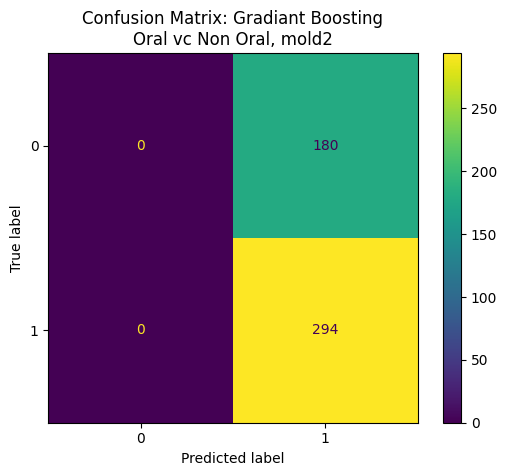

In [71]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

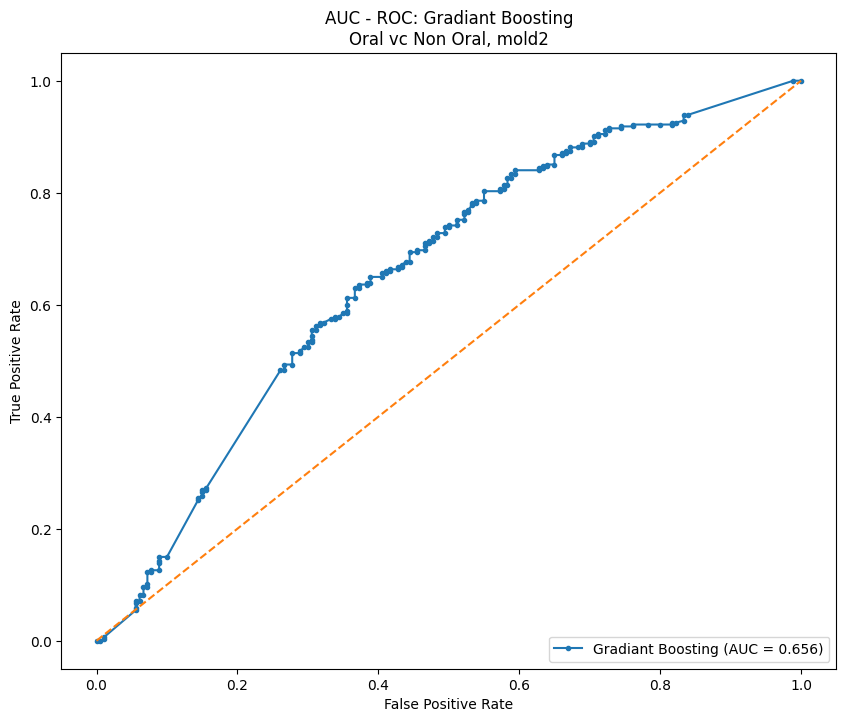

In [72]:
auc_boo = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_boo_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

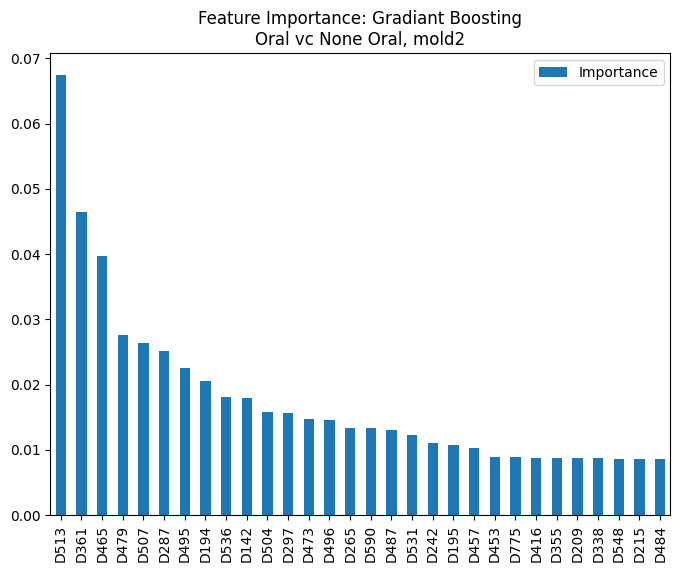

In [73]:
# Print the feature importances

fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(boosting.feature_importances_, index=x_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)

In [74]:
important_features_boo = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_boo

,Importance
D726,6.748379e-20
D328,8.997838e-20
D692,8.997838e-20
D644,1.049748e-19
D332,1.099736e-19
...,...
D507,2.634080e-02
D479,2.766259e-02
D465,3.975954e-02
D361,4.645632e-02


## Saving Results

In [75]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_boo["best_score"][0],
    mis_rate_boo_train,
    mis_rate_boo,
    auc_boo_train,
    auc_boo
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.521203,0.377199,0.379747,0.502222,0.522959
1,Decision Tree,0.618173,0.243490,0.333333,0.689695,0.643188
2,Random Forest,0.705692,0.003519,0.289030,0.996079,0.707870
3,Gradiant Boosting,0.502221,0.378607,0.379747,0.500000,0.655631


In [76]:
important_features_boo.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# BART

## Model Constant Variables

In [77]:
model_name_title = "BART"
model_name_path = "bart"

## Hyperparameter Fine Tuning

In [78]:
# transforming x train and test as arrays for BART procedure

x_train_bart = np.asarray(x_train)
x_test_bart = np.asarray(x_test)

In [79]:
model_params = {
    'BART': {
        'model': BART(),
        'params': {
            'num_trees': [100, 500, 1000],
            'max_stages': [100, 500, 800, 1000], # B, number of iterations
            'burnin': [5, 10, 20]
        }
    }
}

For BART, the auc present in the best_params_grid need to recieve the y_predicted in labels, but this BART algorithm does it in probabilities. Because of this, I need to use a custom scorer, that first transforms the prediction to labels.

In [80]:
score = make_scorer(bart_auc_scorer, greater_is_better=True)

gs_result_bart, gs_result_bart_full = best_params_grid(x_train_bart, y_train, model_params, scoring=score)

Starting Grid Search for BART: 15:00
Finished Grid Search for BART: 19:29
Tempo de execução:  269.6 minutos


In [81]:
gs_result_bart

,model,best_score,best_params
0,BART,0.596815,"{'burnin': 10, 'max_stages': 500, 'num_trees':..."


# Fitting Model

In [82]:
bart_params = gs_result_bart.iloc[0,2]
bart_params

{'burnin': 10, 'max_stages': 500, 'num_trees': 1000}

In [83]:
bart = BART(**bart_params)
bart.fit(x_train_bart, y_train)

BART(burnin=10, max_stages=500, num_trees=1000)

## Get Training Error and AUC

In [84]:
mis_rate_bart_train, auc_bart_train = get_error_and_auc(
    model=bart, 
    x=x_train_bart,
    y_true=y_train,
    transform_prob_into_label=True
)

Training Misclassification Rate: 0.2977
Training AUC: 0.6283


## Make Prediction

In [85]:
# the bart algorithm predicts as probabilities
y_predict_bart_prob = bart.predict(x_test_bart)

In [86]:
# here I use the make_label function to transform the probabilities into labels, using 0.5 as a cutoff

y_predict_bart_label = make_label_v(y_predict_bart_prob)

## Test Error

In [87]:
mis_rate_bart, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_bart_label,
)

Misclassification rate: 0.3354


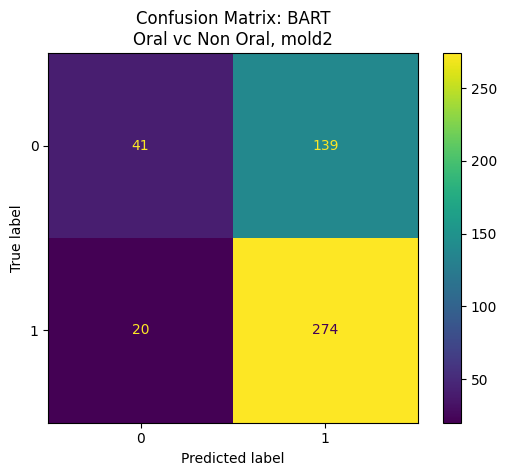

In [88]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

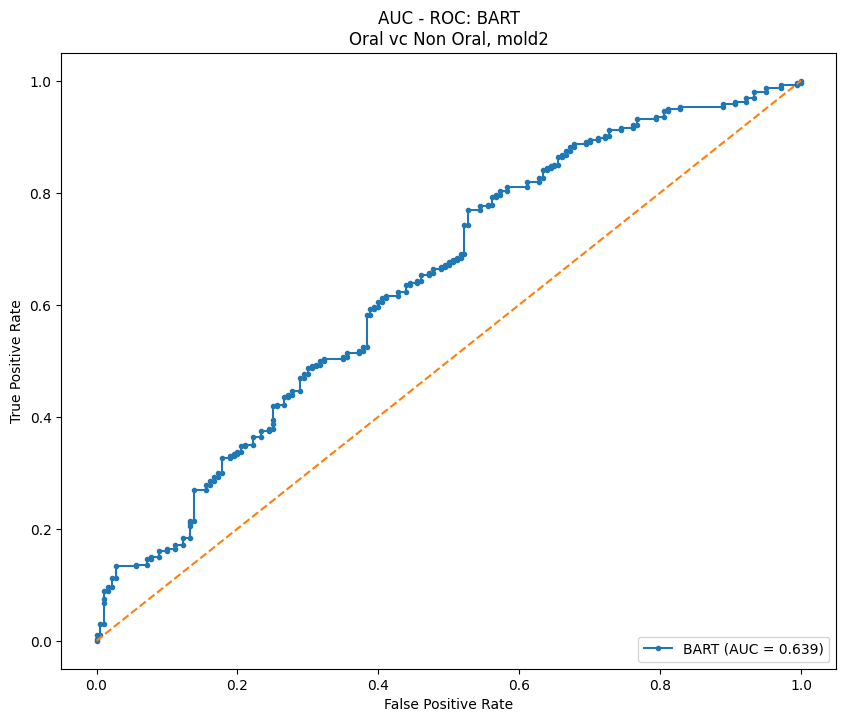

In [89]:
auc_bart = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_bart_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Feature Importance

We can check how many times each variable appeared in the collection
of trees. This gives a summary similar to the variable importance plot for
boosting and random forests.

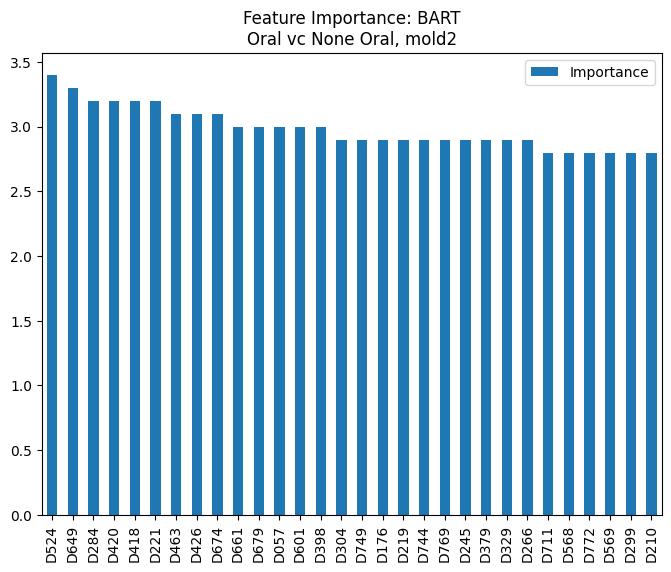

In [90]:
# Print the feature importances
fig, ax = plt.subplots(1, 1)

feat_importances = pd.DataFrame(columns=["Importance"])
feat_importances["Importance"] = pd.Series(bart.variable_inclusion_.mean(0),index=X.columns).sort_values(ascending=False)

feat_importances.iloc[:30,:].plot(kind='bar', figsize=(8,6), ax=ax)
ax.set_title(f"Feature Importance: {model_name_title}\nOral vc None Oral, {DESCRIPTOR_TYPE}")

fig.savefig(f"imgs/feature_importance_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)


In [91]:
important_features_bart = feat_importances[feat_importances.Importance > 0].sort_values(by="Importance")
important_features_bart

,Importance
D400,0.6
D486,0.7
D019,0.7
D005,0.8
D593,0.8
...,...
D418,3.2
D420,3.2
D284,3.2
D649,3.3


## Saving Results

In [92]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_bart["best_score"][0],
    mis_rate_bart_train,
    mis_rate_bart,
    auc_bart_train,
    auc_bart
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.521203,0.377199,0.379747,0.502222,0.522959
1,Decision Tree,0.618173,0.243490,0.333333,0.689695,0.643188
2,Random Forest,0.705692,0.003519,0.289030,0.996079,0.707870
3,Gradiant Boosting,0.502221,0.378607,0.379747,0.500000,0.655631
4,BART,0.596815,0.297678,0.335443,0.628301,0.639172


In [93]:
important_features_bart.to_csv(f"final_results/important_features_{model_name_path}_{DESCRIPTOR_TYPE}.csv", index=False)

# SVM

## Model Constant Variables

In [94]:
model_name_title = "SVM"
model_name_path = "svm"

## Hyperparameter Fine Tuning

In [95]:
scale = 1 / (x_train.shape[1] * x_train.var().mean())

model_params = {
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [0.1, 0.3, 0.5, 0.8, 1.0, 2, 5, 10],
            'kernel': ['rbf', 'sigmoid'],
            'gamma': ['auto', scale, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10]
        }
    }
}

In [96]:
gs_result_svm, gs_result_svm_full = best_params_grid(x_train, y_train, model_params)

Starting Grid Search for SVM: 21:09
Finished Grid Search for SVM: 21:57
Tempo de execução:  48.0 minutos


## Fitting Model

In [97]:
svm_params = gs_result_svm.iloc[0,2]
svm_params

{'C': 1.0, 'gamma': 0.0001, 'kernel': 'rbf'}

In [98]:
svm = SVC(**svm_params, probability=True).fit(x_train, y_train)

## Get Training Error and AUC

In [99]:
mis_rate_svm_train, auc_svm_train = get_error_and_auc(
    model=svm, 
    x=x_train,
    y_true=y_train,
)

Training Misclassification Rate: 0.0035
Training AUC: 0.9957


## Make Prediction

In [100]:
y_predict_svm_label = svm.predict(x_test)
y_predict_svm_prob = svm.predict_proba(x_test)[:, 1]

## Test Error

In [101]:
mis_rate_svm, disp = calculate_confusion_matrix(
    y_test=y_test, 
    y_pred=y_predict_svm_label,
)

Misclassification rate: 0.3734


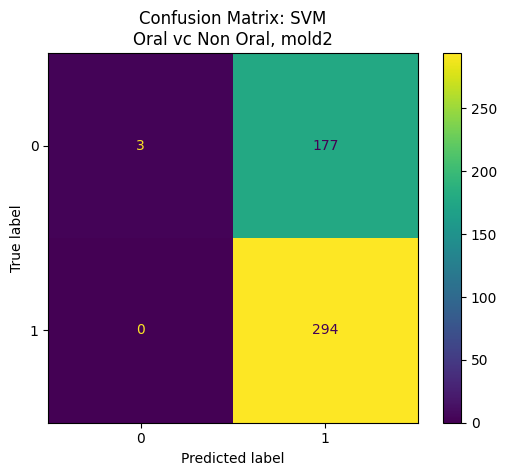

In [102]:
disp.plot()
plt.title(f"Confusion Matrix: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}")
disp.figure_.savefig(f"imgs/cm_{DESCRIPTOR_TYPE}_{model_name_path}", dpi=300)
plt.show()

## ROC/AUC

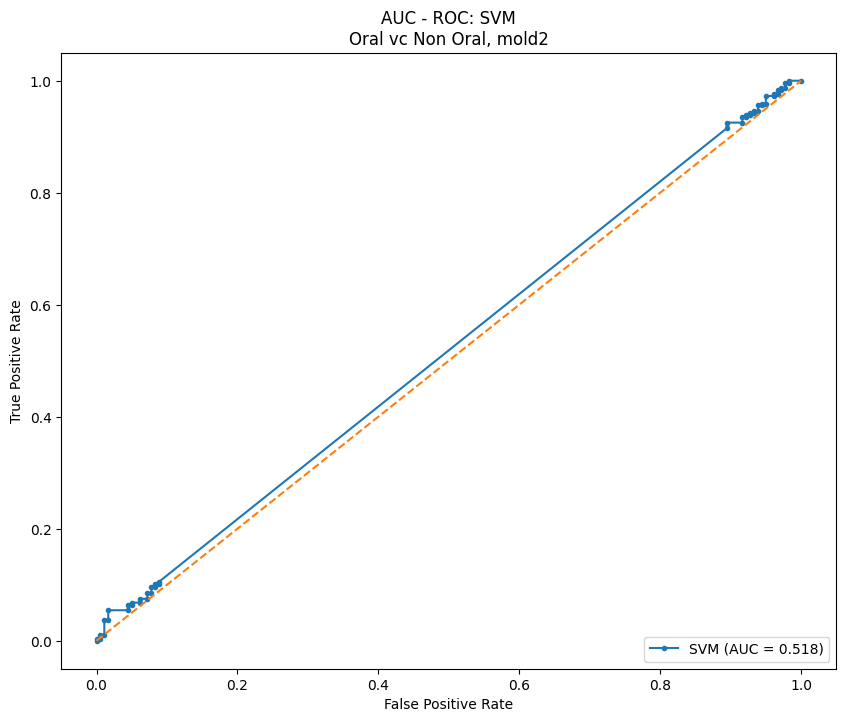

In [103]:
auc_svm = plot_roc_auc_curve(
    y_test=y_test,
    y_pred=y_predict_svm_prob,
    model_name=model_name_title,
    title=f"AUC - ROC: {model_name_title}\nOral vc Non Oral, {DESCRIPTOR_TYPE}",
    save_path=f"imgs/roc_auc_{DESCRIPTOR_TYPE}_{model_name_path}"
)

## Saving Results

In [104]:
final_results.loc[len(final_results.index)] = [
    model_name_title,
    gs_result_svm["best_score"][0],
    mis_rate_svm_train,
    mis_rate_svm,
    auc_svm_train,
    auc_svm
]
final_results

,model_name,cv_test_auc,training_mis_rate,test_mis_rate,training_auc,test_auc
0,Logistic Regression,0.521203,0.377199,0.379747,0.502222,0.522959
1,Decision Tree,0.618173,0.243490,0.333333,0.689695,0.643188
2,Random Forest,0.705692,0.003519,0.289030,0.996079,0.707870
3,Gradiant Boosting,0.502221,0.378607,0.379747,0.500000,0.655631
4,BART,0.596815,0.297678,0.335443,0.628301,0.639172
5,SVM,0.530470,0.003519,0.373418,0.995716,0.517782


# Saving Final Datasets

In [105]:
# saving final_results dataset
final_results.to_csv(f"final_results/models_results_{DESCRIPTOR_TYPE}.csv", index=False)

In [106]:
session_info.show()